In [1]:
import subprocess
from ast import literal_eval

def run(command):
    process = subprocess.Popen(command, shell=True, stdout=subprocess.PIPE)
    out, err = process.communicate()
    print(out.decode('utf-8').strip())

print('# CPU')
run('cat /proc/cpuinfo | egrep -m 1 "^model name"')
run('cat /proc/cpuinfo | egrep -m 1 "^cpu MHz"')
run('cat /proc/cpuinfo | egrep -m 1 "^cpu cores"')

print('# RAM')
run('cat /proc/meminfo | egrep "^MemTotal"')

print('# GPU')
run('lspci | grep VGA')

print('# OS')
run('uname -a')

# CPU
model name	: Intel(R) Xeon(R) CPU @ 2.00GHz
cpu MHz		: 2000.190
cpu cores	: 1
# RAM
MemTotal:       16401976 kB
# GPU

# OS
Linux 27d52c1934f3 5.4.89+ #1 SMP Wed Feb 24 19:44:28 PST 2021 x86_64 x86_64 x86_64 GNU/Linux


In [2]:
import pandas as pd
import numpy as np
import sklearn
from sklearn.model_selection import GroupKFold
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

# import tensorflow_hub as hub
import tensorflow as tf
# import bert_tokenization as tokenization
import tensorflow.keras.backend as K
from tensorflow import keras 

import os
from scipy.stats import spearmanr
from math import floor, ceil
from transformers import *

import seaborn as sns
import string
import re    #for regex

np.set_printoptions(suppress=True)
print(tf.__version__)

2.3.1


# Prep / tokenizer

#### 1. Read data and tokenizer

Read tokenizer and data, as well as defining the maximum sequence length that will be used for the input to Bert (maximum is usually 512 tokens)

In [3]:
training_sample_count = 160000 # 4000
training_epochs = 3 # 3
test_count = 40000

# if True:
#     training_sample_count = 500 # 4000
#     training_epochs = 1 # 3
#     test_count = 300
running_folds = 1 # 2

MAX_SENTENCE_LENGTH = 20
MAX_SENTENCES = 5
MAX_LENGTH = 100

In [4]:
!ls /kaggle/input/200k-short-texts-for-humor-detection

dataset.csv  dev.csv  test.csv	train.csv


### original dataset

In [5]:
df = pd.read_csv('/kaggle/input/200k-short-texts-for-humor-detection/dataset.csv')

df_train = pd.read_csv('/kaggle/input/200k-short-texts-for-humor-detection/train.csv')
display(df_train.head(3))
df_train = df_train[:training_sample_count*running_folds]

df_test = pd.read_csv('/kaggle/input/200k-short-texts-for-humor-detection/dev.csv')
display(df_test.head(3))
df_test = df_test[:test_count]

,text,humor
0,"Joe biden rules out 2020 bid: 'guys, i'm not r...",False
1,Watch: darvish gave hitter whiplash with slow ...,False
2,What do you call a turtle without its shell? d...,True


,text,humor
0,What kind of cat should you take into the des...,True
1,Remember when people used to have to be in sha...,True
2,Pizza is always good. - everyone we'll see abo...,True


In [6]:
test_df_y = df_test.copy()
del df_test['humor']

df_sub = test_df_y.copy()

print(len(df),len(df_train),len(df_test))
display(df_train.head())
display(df_test.head())

200000 160000 40000


,text,humor
0,"Joe biden rules out 2020 bid: 'guys, i'm not r...",False
1,Watch: darvish gave hitter whiplash with slow ...,False
2,What do you call a turtle without its shell? d...,True
3,5 reasons the 2016 election feels so personal,False
4,"Pasco police shot mexican migrant from behind,...",False


,text
0,What kind of cat should you take into the des...
1,Remember when people used to have to be in sha...
2,Pizza is always good. - everyone we'll see abo...
3,"What's 6 inches long hard, bent, and in my pan..."
4,Black teen's response to violence in his commu...


In [7]:
print(list(df_train.columns))

['text', 'humor']


In [8]:
output_categories = list(df_train.columns[[1]])
input_categories = list(df_train.columns[[0]])

TARGET_COUNT = len(output_categories)

print('\ninput categories:\n\t', input_categories)
print('\noutput TARGET_COUNT:\n\t', TARGET_COUNT)
print('\noutput categories:\n\t', output_categories)


input categories:
	 ['text']

output TARGET_COUNT:
	 1

output categories:
	 ['humor']


## 2. Preprocessing functions

These are some functions that will be used to preprocess the raw text data into useable Bert inputs.<br>


In [9]:
from transformers import BertTokenizer

MODEL_TYPE = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(MODEL_TYPE)

In [10]:
import nltk
nltk.download('punkt')
from nltk.tokenize import sent_tokenize

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [11]:
def return_id(str1, str2, truncation_strategy, length):

    inputs = tokenizer.encode_plus(str1, str2,
        add_special_tokens=True,
        max_length=length,
        truncation_strategy=truncation_strategy)

    input_ids =  inputs["input_ids"]
    input_masks = [1] * len(input_ids)
    input_segments = inputs["token_type_ids"]
    padding_length = length - len(input_ids)
    padding_id = tokenizer.pad_token_id
    input_ids = input_ids + ([padding_id] * padding_length)
    input_masks = input_masks + ([0] * padding_length)
    input_segments = input_segments + ([0] * padding_length)

    return [input_ids, input_masks, input_segments]


def compute_input_arrays(df, columns, tokenizer):
    model_input = []
    for xx in range((MAX_SENTENCES*3)+3):
        model_input.append([])
    
    for _, row in tqdm(df[columns].iterrows()):
        i = 0
        
        # sent
        sentences = sent_tokenize(row.text)
        for xx in range(MAX_SENTENCES):
            s = sentences[xx] if xx<len(sentences) else ''
            ids_q, masks_q, segments_q = return_id(s, None, 'longest_first', MAX_SENTENCE_LENGTH)
            model_input[i].append(ids_q)
            i+=1
            model_input[i].append(masks_q)
            i+=1
            model_input[i].append(segments_q)
            i+=1
        
        # full row
        ids_q, masks_q, segments_q = return_id(row.text, None, 'longest_first', MAX_LENGTH)
        model_input[i].append(ids_q)
        i+=1
        model_input[i].append(masks_q)
        i+=1
        model_input[i].append(segments_q)
        
    for xx in range((MAX_SENTENCES*3)+3):
        model_input[xx] = np.asarray(model_input[xx], dtype=np.int32)
        
    print(model_input[0].shape)
    return model_input



In [12]:
inputs      = compute_input_arrays(df_train, input_categories, tokenizer)
test_inputs = compute_input_arrays(df_test, input_categories, tokenizer)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.



(160000, 20)



(40000, 20)


In [13]:
print(len(inputs), len(inputs[0]), len(inputs[0][0]))

# check out input for 7th row
xx = 7
print(df_train.iloc[xx,0])
print(sent_tokenize(df_train.iloc[xx,0]))
inputs[0][xx], inputs[3][xx], inputs[6][xx], inputs[15][xx]

18 160000 20
Why do native americans hate it when it rains in april? because it brings mayflowers.
['Why do native americans hate it when it rains in april?', 'because it brings mayflowers.']


(array([  101,  2339,  2079,  3128,  4841,  5223,  2009,  2043,  2009,
        15811,  1999,  2258,  1029,   102,     0,     0,     0,     0,
            0,     0], dtype=int32),
 array([  101,  2138,  2009,  7545,  2089, 14156,  2015,  1012,   102,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0], dtype=int32),
 array([101, 102,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0], dtype=int32),
 array([  101,  2339,  2079,  3128,  4841,  5223,  2009,  2043,  2009,
        15811,  1999,  2258,  1029,  2138,  2009,  7545,  2089, 14156,
         2015,  1012,   102,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,

In [14]:
def compute_output_arrays(df, columns):
    return np.asarray(df[columns])

outputs = compute_output_arrays(df_train, output_categories)
outputs

array([[False],
       [False],
       [ True],
       ...,
       [ True],
       [ True],
       [False]])

## 3. Create model



In [15]:
config = BertConfig() # print(config) to see settings
config.output_hidden_states = False # Set to True to obtain hidden states
bert_model = TFBertModel.from_pretrained('bert-base-uncased', config=config)
config

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


BertConfig {
  "_name_or_path": "bert-base-uncased",
  "attention_probs_dropout_prob": 0.1,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "type_vocab_size": 2,
  "vocab_size": 30522
}

In [16]:
def create_model():
    # model structure
    # takes q_ids [max=20*MAX_SENTENCES] and a_ids [max=200]
    import gc
    
    model_inputs = []
    f_inputs=[]
    for i in range(MAX_SENTENCES):
        # bert embeddings
        q_id = tf.keras.layers.Input((MAX_SENTENCE_LENGTH,), dtype=tf.int32)
        q_mask = tf.keras.layers.Input((MAX_SENTENCE_LENGTH,), dtype=tf.int32)
        q_atn = tf.keras.layers.Input((MAX_SENTENCE_LENGTH,), dtype=tf.int32)
        q_embedding = bert_model.bert(q_id, attention_mask=q_mask, token_type_ids=q_atn)[0]
        q = tf.keras.layers.GlobalAveragePooling1D()(q_embedding)
        
        # internal model
        hidden1 = keras.layers.Dense(32, activation="relu")(q)
        hidden2 = keras.layers.Dropout(0.3)(hidden1)
        hidden3 = keras.layers.Dense(8, activation='relu')(hidden2)
        
        f_inputs.append(hidden3)
        model_inputs.extend([q_id, q_mask, q_atn])
        
    # whole sentence
    a_id = tf.keras.layers.Input((MAX_LENGTH,), dtype=tf.int32)
    a_mask = tf.keras.layers.Input((MAX_LENGTH,), dtype=tf.int32)
    a_atn = tf.keras.layers.Input((MAX_LENGTH,), dtype=tf.int32)
    a_embedding = bert_model.bert(a_id, attention_mask=a_mask, token_type_ids=a_atn)[0]
    a = tf.keras.layers.GlobalAveragePooling1D()(a_embedding)
    print(a.shape)
    # internal model
    hidden1 = keras.layers.Dense(256, activation="relu")(a)
    hidden2 = keras.layers.Dropout(0.2)(hidden1)
    hidden3 = keras.layers.Dense(64, activation='relu')(hidden2)

    f_inputs.append(hidden3)
    model_inputs.extend([a_id, a_mask, a_atn])
    
    # final classifier
    concat_ = keras.layers.Concatenate()(f_inputs)
    hiddenf1 = keras.layers.Dense(512, activation='relu')(concat_)
    hiddenf2 = keras.layers.Dropout(0.2)(hiddenf1)
    hiddenf3 = keras.layers.Dense(256, activation='relu')(hiddenf2)
    
    output = keras.layers.Dense(TARGET_COUNT, activation='sigmoid')(hiddenf3) # softmax
    model = keras.Model(inputs=model_inputs, outputs=[output] )
    
    gc.collect()
    return model

model = create_model()

(None, 768)


In [17]:
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 20)]         0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 20)]         0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 20)]         0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 20)]         0                                            
_______________________________________________________________________________________

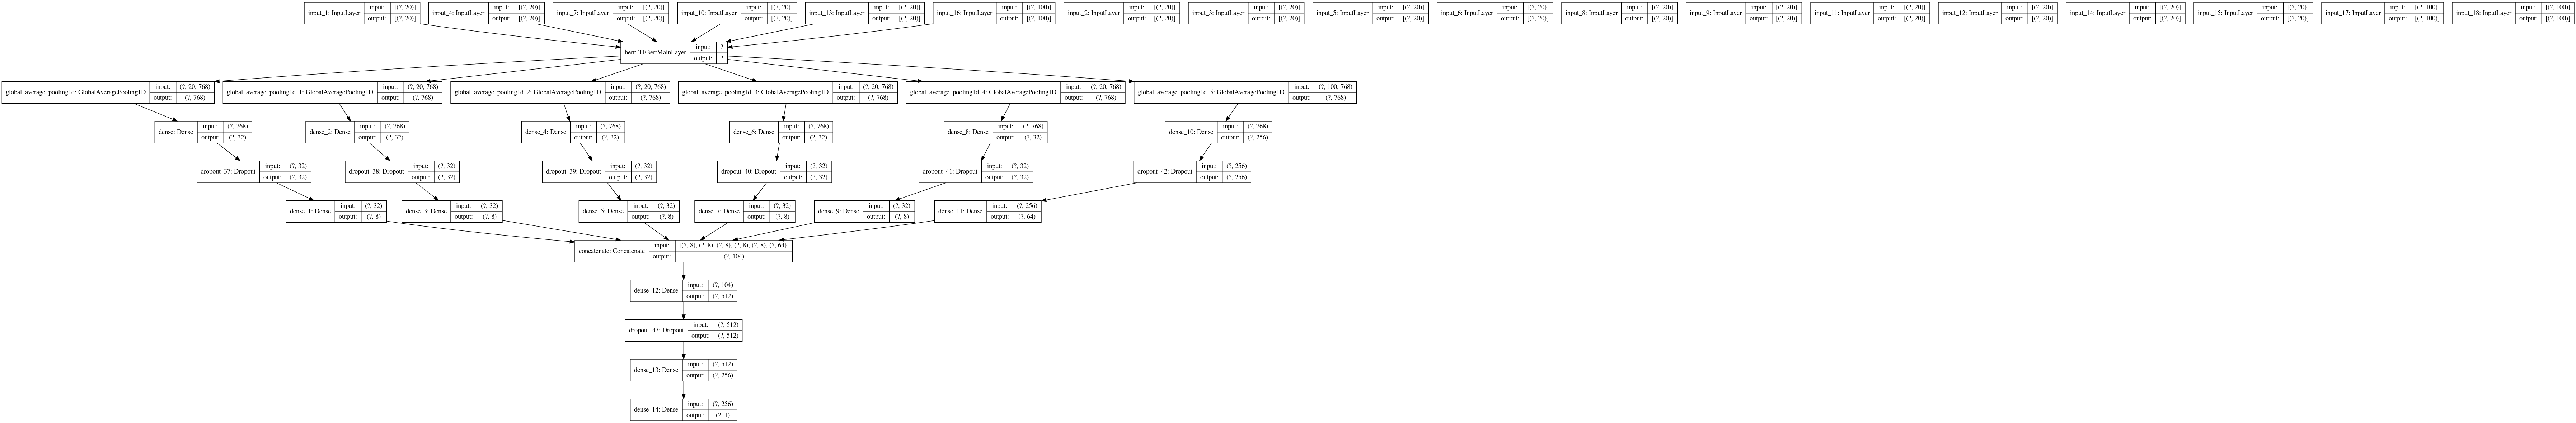

In [18]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

## 5. Training, validation and testing

Loops over the folds in gkf and trains each fold for 3 epochs --- with a learning rate of 3e-5 and batch_size of 6. A simple binary crossentropy is used as the objective-/loss-function. 

In [19]:
# Evaluation Metrics
import sklearn
def print_evaluation_metrics(y_true, y_pred, label='', is_regression=True, label2=''):
    print('==================', label2)
    ### For regression
    if is_regression:
        print('mean_absolute_error',label,':', sklearn.metrics.mean_absolute_error(y_true, y_pred))
        print('mean_squared_error',label,':', sklearn.metrics.mean_squared_error(y_true, y_pred))
        print('r2 score',label,':', sklearn.metrics.r2_score(y_true, y_pred))
        #     print('max_error',label,':', sklearn.metrics.max_error(y_true, y_pred))
        return sklearn.metrics.mean_squared_error(y_true, y_pred)
    else:
        ### FOR Classification
#         print('balanced_accuracy_score',label,':', sklearn.metrics.balanced_accuracy_score(y_true, y_pred))
#         print('average_precision_score',label,':', sklearn.metrics.average_precision_score(y_true, y_pred))
#         print('balanced_accuracy_score',label,':', sklearn.metrics.balanced_accuracy_score(y_true, y_pred))
#         print('accuracy_score',label,':', sklearn.metrics.accuracy_score(y_true, y_pred))
        print('f1_score',label,':', sklearn.metrics.f1_score(y_true, y_pred))
        
        matrix = sklearn.metrics.confusion_matrix(y_true, y_pred)
        print(matrix)
        TP,TN,FP,FN = matrix[1][1],matrix[0][0],matrix[0][1],matrix[1][0]
        Accuracy = (TP+TN)/(TP+FP+FN+TN)
        Precision = TP/(TP+FP)
        Recall = TP/(TP+FN)
        F1 = 2*(Recall * Precision) / (Recall + Precision)
        print('Acc', Accuracy, 'Prec', Precision, 'Rec', Recall, 'F1',F1)
        return sklearn.metrics.accuracy_score(y_true, y_pred)

print_evaluation_metrics([1,0], [0.9,0.1], '', True)
print_evaluation_metrics([1,0], [1,1], '', False)

mean_absolute_error  : 0.09999999999999999
mean_squared_error  : 0.009999999999999998
r2 score  : 0.96
f1_score  : 0.6666666666666666
[[0 1]
 [0 1]]
Acc 0.5 Prec 0.5 Rec 1.0 F1 0.6666666666666666


0.5

### Loss function selection
Regression problem between 0 and 1, so binary_crossentropy and mean_absolute_error seem good.

Here are the explanations: https://www.dlology.com/blog/how-to-choose-last-layer-activation-and-loss-function/

In [20]:
min_acc = 100
min_test = []
valid_preds = []
test_preds = []
best_model = False
for BS in [6]:
    LR = 1e-5
    print('>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>')
    print('LR=', LR)
    gkf = GroupKFold(n_splits=2).split(X=df_train.text, groups=df_train.text)

    for fold, (train_idx, valid_idx) in enumerate(gkf):
        if fold not in range(running_folds):
            continue
        train_inputs = [(inputs[i][train_idx])[:training_sample_count] for i in range(len(inputs))]
        train_outputs = (outputs[train_idx])[:training_sample_count]

        valid_inputs = [inputs[i][valid_idx] for i in range(len(inputs))]
        valid_outputs = outputs[valid_idx]

        print(len(train_idx), len(train_outputs))
#         print(train_idx[:10], valid_idx[:10])

        model = create_model()
        K.clear_session()
        optimizer = tf.keras.optimizers.Adam(learning_rate=LR)
        model.compile(loss='binary_crossentropy', optimizer=optimizer)
        print('model compiled')
        
        model.fit(train_inputs, train_outputs, epochs=training_epochs, batch_size=BS,
                 validation_split=0.2, verbose=1,
#                  validation_data=(x_val, y_val)
                 )
        
        model.save_weights(f'bert-{fold}.h5')

        valid_preds.append(model.predict(valid_inputs))
        acc = print_evaluation_metrics(np.array(valid_outputs), np.array(valid_preds[-1]), 'on #'+str(xx+1))
        if acc < min_acc:
            print('new acc >> ', acc)
            min_acc = acc
            best_model = model
#                 min_test = model.predict(test_inputs)
#                 test_preds.append(min_test)

>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
LR= 1e-05
80000 80000
(None, 768)
model compiled
Epoch 1/3
10667/10667 [==============================] - 3679s 345ms/step - loss: 0.0695 - val_loss: 0.0440
Epoch 2/3
10667/10667 [==============================] - 3696s 347ms/step - loss: 0.0222 - val_loss: 0.0431
Epoch 3/3
10667/10667 [==============================] - 3720s 349ms/step - loss: 0.0099 - val_loss: 0.0496
mean_absolute_error on #8 : 0.016925473
mean_squared_error on #8 : 0.012227797
r2 score on #8 : 0.9510884324146058
new acc >>  0.012227797


In [21]:
# https://machinelearningmastery.com/save-load-keras-deep-learning-models/
# serialize model to JSON
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model.h5")
print("Saved model to disk")

Saved model to disk


In [22]:
# https://www.javaer101.com/en/article/18162646.html
model.save('my_model.h5') 

In [23]:
model.save("colbert-trained")


In [24]:
# https://keras.io/guides/serialization_and_saving/


In [25]:
print('best acc >> ', acc)

best acc >>  0.012227797


In [26]:
len(valid_inputs[0])

80000

In [27]:
print(valid_outputs.shape, valid_preds[-1].shape)
print_evaluation_metrics(np.array(valid_outputs), np.array(valid_preds[-1]), '')

(80000, 1) (80000, 1)
mean_absolute_error  : 0.016925473
mean_squared_error  : 0.012227797
r2 score  : 0.9510884324146058


0.012227797

In [28]:
# %%time
min_test = best_model.predict(test_inputs)

## use min_test
# min_test

In [29]:
df_test.to_csv('df_test.csv')
test_df_y.to_csv('test_df_y.csv')


## Regression submission

In [30]:
df_sub = test_df_y.copy()
# df_sub['pred'] = np.average(test_preds, axis=0) # for weighted average set weights=[...]
df_sub['pred'] = min_test


print_evaluation_metrics(df_sub['humor'], df_sub['pred'], '', True)


df_sub.to_csv('sub1.csv', index=False)
df_sub.head()

mean_absolute_error  : 0.017012216
mean_squared_error  : 0.01243615
r2 score  : 0.9502545684127843


,text,humor,pred
0,What kind of cat should you take into the des...,True,0.999954
1,Remember when people used to have to be in sha...,True,0.885077
2,Pizza is always good. - everyone we'll see abo...,True,0.999956
3,"What's 6 inches long hard, bent, and in my pan...",True,0.999980
4,Black teen's response to violence in his commu...,False,0.000116


## Binary submission

In [31]:
for split in np.arange(0.1, 0.99, 0.1).tolist():
    df_sub['pred_bi'] = (df_sub['pred'] > split)

    print_evaluation_metrics(df_sub['humor'], df_sub['pred_bi'], '', False, 'SPLIT on '+str(split))

    df_sub.to_csv('sub3.csv', index=False)
    df_sub.head()

================== SPLIT on 0.1
f1_score  : 0.9806121444739692
[[19284   634]
 [  154 19928]]
Acc 0.9803 Prec 0.9691664234996595 Rec 0.9923314410915247 F1 0.9806121444739692
================== SPLIT on 0.2
f1_score  : 0.983292140385566
[[19432   486]
 [  190 19892]]
Acc 0.9831 Prec 0.9761507508096967 Rec 0.990538790957076 F1 0.983292140385566
================== SPLIT on 0.30000000000000004
f1_score  : 0.9842921559883058
[[19502   416]
 [  218 19864]]
Acc 0.98415 Prec 0.9794871794871794 Rec 0.9891445075191714 F1 0.9842921559883058
================== SPLIT on 0.4
f1_score  : 0.9847612429266356
[[19547   371]
 [  243 19839]]
Acc 0.98465 Prec 0.9816427511133102 Rec 0.9878996115924709 F1 0.9847612429266356
================== SPLIT on 0.5
f1_score  : 0.9850857568978374
[[19585   333]
 [  267 19815]]
Acc 0.985 Prec 0.9834723049434188 Rec 0.9867045115028383 F1 0.9850857568978374
================== SPLIT on 0.6
f1_score  : 0.9851682261596655
[[19610   308]
 [  288 19794]]
Acc 0.9851 Prec 0.9846

In [32]:
df_sub['pred_bi'] = (df_sub['pred'] > 0.5)

print_evaluation_metrics(df_sub['humor'], df_sub['pred_bi'], '', False, 'SPLIT on '+str(split))

df_sub.to_csv('sub3.csv', index=False)
df_sub.head()

================== SPLIT on 0.9
f1_score  : 0.9850857568978374
[[19585   333]
 [  267 19815]]
Acc 0.985 Prec 0.9834723049434188 Rec 0.9867045115028383 F1 0.9850857568978374


,text,humor,pred,pred_bi
0,What kind of cat should you take into the des...,True,0.999954,True
1,Remember when people used to have to be in sha...,True,0.885077,True
2,Pizza is always good. - everyone we'll see abo...,True,0.999956,True
3,"What's 6 inches long hard, bent, and in my pan...",True,0.999980,True
4,Black teen's response to violence in his commu...,False,0.000116,False


In [33]:
df_sub[df_sub['pred_bi']!=df_sub['humor']]

,text,humor,pred,pred_bi
252,Ariana grande looks like she was designed in a...,True,0.023232,False
303,"If you're happy and you know it, share your meds",True,0.003352,False
309,Friends don't let friends make harlem shake' v...,True,0.278334,False
310,The whip was especially popular in the 1800's,True,0.038513,False
345,One out of five dentists has the courage to sp...,True,0.005155,False
...,...,...,...,...
39874,Scary but true: statistics show that everyone ...,True,0.009534,False
39877,On the money! a female face on the ten dollar ...,False,0.981126,True
39889,Seminar topic at the annual vampire conference...,True,0.003524,False
39955,A recent study by un has found dexter to be th...,True,0.172858,False
